In [1]:
import os
from prefect import task, Flow
import qcodes as qc
import nanotune as nt

nt.new_database('prefect_demo.db', os.getcwd())
qc.new_experiment('prefect_demo', 'no_sample')

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jana/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jana/.qcodes/logs/210528-74109-qcodes.log


prefect_demo#no_sample#6@/Users/jana/Documents/code/nanotune/nanotune/docs/examples/prefect_demo.db
---------------------------------------------------------------------------------------------------

In [2]:
%run load_station.py

C01R01_gate step 0.0005
C01R01_gate inter_delay 0.00125


In [3]:
%run train_classifier.py

/Users/jana/Documents/code/nanotune/nanotune/data/training_data/pinchoff.npy
n_samples: 3699


In [4]:
qc.config["core"]

{'default_fmt': 'data/{date}/#{counter}_{name}_{time}',
 'register_magic': True,
 'import_legacy_api': False,
 'db_location': '/Users/jana/Documents/code/nanotune/nanotune/docs/examples/prefect_demo.db',
 'db_debug': False,
 'loglevel': 'WARNING',
 'file_loglevel': 'INFO'}

In [5]:
from typing import Tuple

from nanotune.tuningstages.base_tasks import (
    SetpointSettingsDict,
    DataSettingsDict,
    ReadoutMethodsDict,
    compute_linear_setpoints,
    swap_range_limits_if_needed,
    get_current_voltages,
    take_data_add_metadata,
    set_up_gates_for_measurement,
    prepare_metadata,
    get_extracted_features,
    check_measurement_quality
)

from nanotune.tuningstages.take_data import ramp_to_setpoint
from nanotune.fit.pinchofffit import PinchoffFit

In [6]:
mux.drive(True)

In [7]:
@task
def create_settings() -> Tuple[SetpointSettingsDict, ReadoutMethodsDict, DataSettingsDict]:
    setpoint_settings = SetpointSettingsDict(
        parameters_to_sweep=[chip.C01R01.gate], # gates to sweep (only 1D or 2D)
        current_valid_ranges=[(-2.0, 0.0)], # expected range of pinch-off
        safety_voltage_ranges=[(-3.0, 0.0)], # maximum voltages allowed
        voltage_precision=0.01 # sweep step size
    )

    readout_methods = ReadoutMethodsDict(
        dc_current = chip.C01R01.drain, # transport through the device
        #dc_sensor = chip.C01R01.drain, # optional extra current sensing
        rf = mux.readout # RF readout
    )

    data_settings = DataSettingsDict(
        db_name="prefect_demo",
        db_folder=os.getcwd(),
        normalization_constants={"foo": (1.0, 1.0)},
        segment_size=1,
    )

    return (
        setpoint_settings,
        readout_methods,
        data_settings
    )

In [8]:
@task
def compute_setpoints(setpoint_settings):
    initial_voltages = get_current_voltages(
        setpoint_settings["parameters_to_sweep"]
    )

    current_valid_ranges = swap_range_limits_if_needed(
        initial_voltages,
        setpoint_settings["current_valid_ranges"]
    )

    setpoints = compute_linear_setpoints(
        current_valid_ranges,
        setpoint_settings["voltage_precision"],
    )
    return setpoints

In [9]:
@task
def measure(setpoints, setpoint_settings, data_settings, readout_methods):
    example_param = setpoint_settings["parameters_to_sweep"][0]
    device_name = example_param.name_parts[0]
    nt_meta = prepare_metadata(
        chip.C01R01.name,
        data_settings["normalization_constants"],
        readout_methods,
    )
    dc_sensor = readout_methods.get("dc_sensor")
    rf = readout_methods.get("rf")

    def finish_early(current_output_dict):
        if dc_sensor is not None:
            dc_value = current_output_dict[str(dc_sensor)]
        dc_value = 0.0
        rf_value = current_output_dict[str(rf)]
        return dc_value < 0.0001 and rf_value < 0.0001

    run_id = take_data_add_metadata(
        setpoint_settings["parameters_to_sweep"],
        list(readout_methods.values()),  # type: ignore
        setpoints,
        finish_early_check=finish_early,
        do_at_inner_setpoint=ramp_to_setpoint,
        pre_measurement_metadata=nt_meta,
    )

    return run_id

In [10]:
@task
def plot(run_id, setpoint_settings, readout_methods):
    ds = qc.load_by_id(run_id)
    gate = setpoint_settings["parameters_to_sweep"][0]
    dc_sensor = readout_methods.get("dc_sensor")
    rf = readout_methods.get("rf")
    df_dict = ds.to_pandas_dataframe_dict()
    if dc_sensor is not None:
        return [df_dict[str(dc_sensor)].plot(), df_dict[str(rf)].plot()]
    return df_dict[str(rf)].plot()

In [11]:
@task
def extract_features(run_id, data_settings):
    ml_result: Dict[str, Any] = {}
    ml_result["features"] = get_extracted_features(
        PinchoffFit,
        run_id,
        data_settings["db_name"],
        db_folder=data_settings["db_folder"],
    )
    ml_result["quality"] = check_measurement_quality(
        classifier,
        run_id,
        data_settings["db_name"],
        db_folder=data_settings["db_folder"],
    )
    ml_result["regime"] = "pinchoff"
    return ml_result

In [12]:
@task
def save_features(run_id, ml_result, data_settings):
    save_extracted_features(
        PinchoffFit,
        run_id,
        data_settings["db_name"],
        db_folder=data_settings["db_folder"],
    )
    save_machine_learning_result(run_id, ml_result)

In [13]:
@task
def verify_result(ml_result):
    return bool(ml_result["quality"])

In [14]:
with Flow("Pinch-off") as flow:
    (setpoint_settings, readout_methods, data_settings) = create_settings()
    setpoints = compute_setpoints(setpoint_settings)
    run_id = measure(setpoints, setpoint_settings, data_settings, readout_methods)
    figs = plot(run_id, setpoint_settings, readout_methods)
    # features = extract_features(run_id, data_settings)
    # save_features(run_id, features, data_settings)
    # success = verify_result(features)

[2021-05-28 10:44:00+0200] INFO - prefect.FlowRunner | Beginning Flow run for 'Pinch-off'
[2021-05-28 10:44:00+0200] INFO - prefect.TaskRunner | Task 'create_settings': Starting task run...
[2021-05-28 10:44:00+0200] INFO - prefect.TaskRunner | Task 'create_settings': Finished task run for task with final state: 'Success'
[2021-05-28 10:44:00+0200] INFO - prefect.TaskRunner | Task 'create_settings[0]': Starting task run...
[2021-05-28 10:44:01+0200] INFO - prefect.TaskRunner | Task 'create_settings[0]': Finished task run for task with final state: 'Success'
[2021-05-28 10:44:01+0200] INFO - prefect.TaskRunner | Task 'compute_setpoints': Starting task run...
[2021-05-28 10:44:01+0200] INFO - prefect.TaskRunner | Task 'compute_setpoints': Finished task run for task with final state: 'Success'
[2021-05-28 10:44:01+0200] INFO - prefect.TaskRunner | Task 'create_settings[2]': Starting task run...
[2021-05-28 10:44:01+0200] INFO - prefect.TaskRunner | Task 'create_settings[2]': Finished task

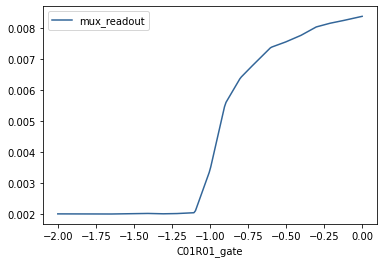

In [15]:
state = flow.run()

In [16]:
state

<Success: "All reference tasks succeeded.">

In [17]:
dataset = qc.load_by_id(state.result[run_id].result)

In [18]:
dataset.to_pandas_dataframe()

,C01R01_drain,mux_readout
C01R01_gate,,
0.000000,2.399828e-03,0.008380
-0.010050,2.400045e-03,0.008369
-0.020101,2.400262e-03,0.008357
-0.030151,2.400479e-03,0.008346
-0.040201,2.400696e-03,0.008335
...,...,...
-1.959799,-3.759480e-07,0.002004
-1.969849,-3.921679e-07,0.002004
-1.979899,-4.083877e-07,0.002004


In [19]:
_data_settings = state.result[data_settings].result

In [22]:
ml_result = extract_features.run(5, _data_settings)

2021-05-28 10:44:35,936 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 245 ¦ ('Dataset 5: ', 'Wrong normalization constant')
2021-05-28 10:44:36,041 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 245 ¦ ('Dataset 5: ', 'Wrong normalization constant')


In [23]:
ml_result

{'features': {'dc_current': {'amplitude': 0.0011167654865272606,
   'slope': 9.903137863310576,
   'offset': -5.232725543121401,
   'residuals': 0.0733490041452782,
   'low_voltage': -1.11557788944724,
   'high_voltage': -0.844221105527638,
   'low_signal': 6.0708748950183076e-05,
   'high_signal': 0.0016126905821371548,
   'transition_voltage': -1.07537688442211,
   'transition_signal': 0.00038377373992561157,
   'max_signal': 0.00240069555877538,
   'min_signal': -4.40827416964233e-07},
  'rf': {'amplitude': 0.005092037579797305,
   'slope': 2.304189366203748,
   'offset': -1.3004700128233273,
   'residuals': 0.14330697910246598,
   'low_voltage': -1.10552763819095,
   'high_voltage': -0.773869346733668,
   'low_signal': 0.0021171215117249,
   'high_signal': 0.006521587085086477,
   'transition_voltage': -0.954773869346734,
   'transition_signal': 0.0043826023999943235,
   'max_signal': 0.00837996416850713,
   'min_signal': 0.00200014074048982}},
 'quality': False,
 'regime': 'pincho